In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #绘图库
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为新宋体。
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时'-'显示为方块的问题。
import seaborn as sns   #绘图库
import plotly.graph_objects as go  #绘图库
import matplotlib.cm as cm  #渐变色
from sklearn.model_selection import train_test_split   #训练集测试集划分
from sklearn.ensemble import RandomForestClassifier    #随机森林相关库
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score        #模型精度评分
from sklearn.metrics import confusion_matrix           #混淆矩阵表
from sklearn import svm  #支持向量机
from sklearn.neural_network import MLPClassifier  #BP神经网络
import xgboost as xgb    #xgboost
from sklearn import preprocessing  #xgboost编码器
from io import StringIO
from IPython.display import display   #用于展示多个styler

from sklearn.preprocessing import LabelEncoder

import matplotlib.ticker as ticker

from sklearn.linear_model import LinearRegression    #引入线性回归分析
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import f_oneway



from sklearn.model_selection import cross_val_score  #模拟退火算法需求
import math
import random
import torch

import matplotlib.dates as mdates   ## 日期格式化





# 检查是否有可用的 GPU
if torch.cuda.is_available():
    device = torch.device("cuda")  # 使用 
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")  # 使用 CPU
    print("Using CPU")

Using GPU: NVIDIA GeForce MX450


#### 数据处理 添加季节

In [19]:
# 加载 csv文件
data = pd.read_csv('PekingAirqulityDetails.csv')
data

,日期,AQI,质量等级,PM2.5,PM10,NO2,CO,SO2,O3_8h
0,2013/12/2,142,轻度污染,109,138,88,2.6,61,11
1,2013/12/3,86,良,64,86,54,1.6,38,45
2,2013/12/4,109,轻度污染,82,101,62,2.0,42,23
3,2013/12/5,56,良,39,56,38,1.2,30,52
4,2013/12/6,169,中度污染,128,162,78,2.5,48,15
...,...,...,...,...,...,...,...,...,...
3676,2023/12/26,55,良,26,46,44,0.7,3,0
3677,2023/12/27,64,良,45,71,51,0.8,3,34
3678,2023/12/28,129,轻度污染,98,132,69,1.2,3,21
3679,2023/12/29,150,轻度污染,115,145,62,1.2,3,45


In [20]:
# 添加一列作为季节
data['日期'] = pd.to_datetime(data['日期'])

# 根据日期的月份来创建季节的映射
seasons_mapping = {1: '冬', 2: '冬', 3: '春', 4: '春', 5: '春', 6: '夏',
                  7: '夏', 8: '夏', 9: '秋', 10: '秋', 11: '秋', 12: '冬'}

# 使用map函数将月份列转换为季节
data['季节'] = data['日期'].dt.month.map(seasons_mapping)
data
# 创建一个列名列表，包含你希望出现的所有列，并按照你想要的顺序进行排序
columns_ordered = ['日期','季节','AQI','质量等级','PM2.5','PM10','NO2','CO','SO2','O3_8h']
# 重新排序DataFrame的列
data = data[columns_ordered]
data.to_csv('SeasonAdded.csv',encoding='utf-8',index=False)
data

,日期,季节,AQI,质量等级,PM2.5,PM10,NO2,CO,SO2,O3_8h
0,2013-12-02,冬,142,轻度污染,109,138,88,2.6,61,11
1,2013-12-03,冬,86,良,64,86,54,1.6,38,45
2,2013-12-04,冬,109,轻度污染,82,101,62,2.0,42,23
3,2013-12-05,冬,56,良,39,56,38,1.2,30,52
4,2013-12-06,冬,169,中度污染,128,162,78,2.5,48,15
...,...,...,...,...,...,...,...,...,...,...
3676,2023-12-26,冬,55,良,26,46,44,0.7,3,0
3677,2023-12-27,冬,64,良,45,71,51,0.8,3,34
3678,2023-12-28,冬,129,轻度污染,98,132,69,1.2,3,21
3679,2023-12-29,冬,150,轻度污染,115,145,62,1.2,3,45


#### 相关性分析

AQI的Pearson相关性分析: 
AQI      1.000000
PM2.5    0.863576
PM10     0.800854
CO       0.706213
NO2      0.612835
SO2      0.451434
O3_8h    0.230818
Name: AQI, dtype: float64


AQI的Spearman相关性分析: 
AQI      1.000000
PM2.5    0.806210
PM10     0.762350
CO       0.674557
NO2      0.532252
SO2      0.401957
O3_8h    0.310576
Name: AQI, dtype: float64




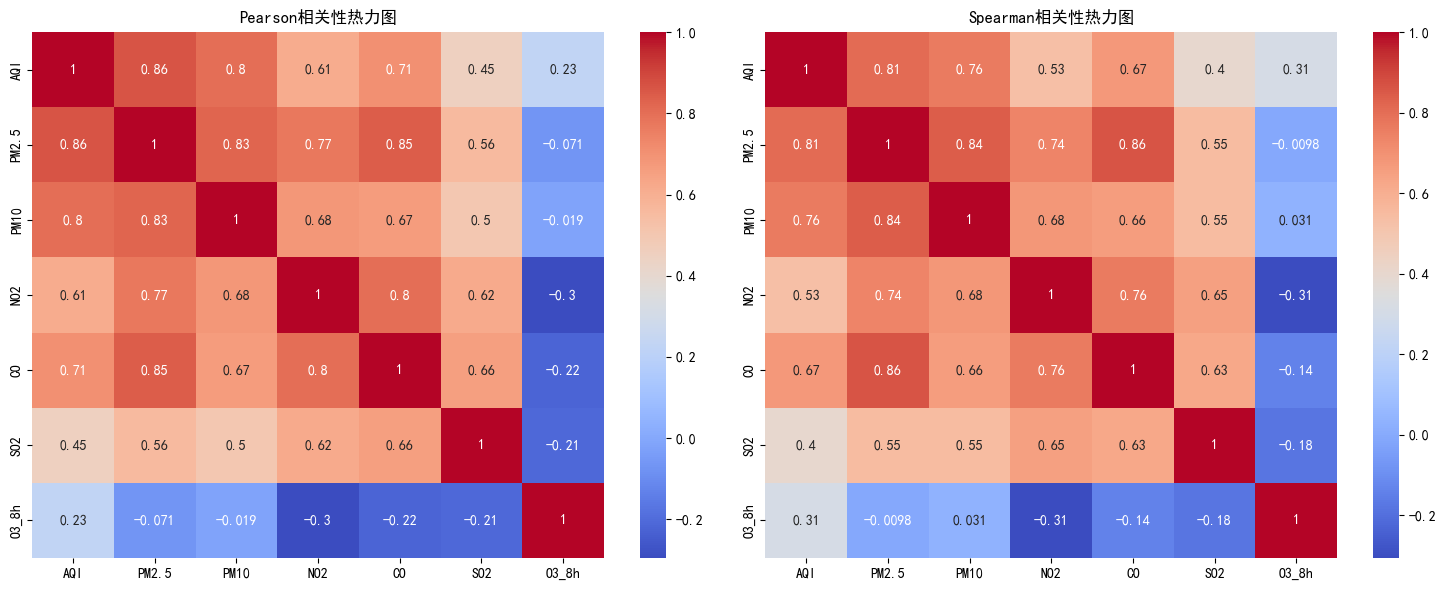

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6900\1468341251.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=pearson_corr_AQI.index[1:], x=pearson_corr_AQI.values[1:], orient='h', palette="viridis")


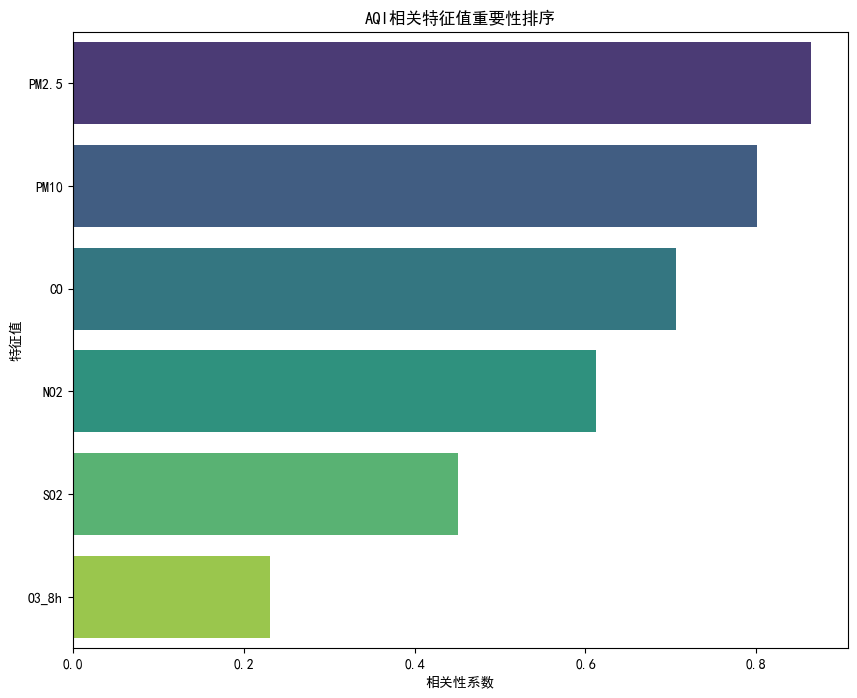

In [21]:
# 相关性分析
# 想要知道哪个属性和 'AQI' 的相关性最大

# 去除非数值的列
numeric_data = data.drop(['日期', '季节', '质量等级'], axis=1)

# define pearson方法
pearson_corr = numeric_data.corr(method='pearson')

# define spearman方法
spearman_corr = numeric_data.corr(method='spearman')

# 使用pearson相关系数
pearson_corr_AQI = pearson_corr['AQI'].sort_values(ascending=False)

# 使用spearman相关系数
spearman_corr_AQI = spearman_corr['AQI'].sort_values(ascending=False)

# 输出Pearson相关性分析表
print("AQI的Pearson相关性分析: ")
print(pearson_corr_AQI)
print("\n")

# 输出Spearman相关性分析表
print("AQI的Spearman相关性分析: ")
print(spearman_corr_AQI)
print("\n")

# 创建一个新的图形
plt.figure(figsize=(15, 6))

#字体为 SimHei
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

# 创建Pearson相关性分析的热力图
plt.subplot(1,2,1)
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm')
plt.title("Pearson相关性热力图")

# 创建Spearman相关性分析的热力图
plt.subplot(1,2,2)
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm')
plt.title("Spearman相关性热力图")

# 显示图形
plt.tight_layout()
plt.show()

## 生成特征值的柱状图
# 创建一个新的图形
plt.figure(figsize=(10, 8))

# 生成降序的柱状图
sns.barplot(y=pearson_corr_AQI.index[1:], x=pearson_corr_AQI.values[1:], orient='h', palette="viridis")
# 'AQI'和自己的相关性为1，我们在这里省略了相关系数为1的这一项

# 添加图形标题
plt.title("AQI相关特征值重要性排序")

# 添加x轴和y轴的标签
plt.xlabel("相关性系数")
plt.ylabel("特征值")

# 显示图形
plt.show()

In [28]:
from scipy.stats import f_oneway

numeric_data = data.select_dtypes(include = ['float64', 'int64'])  # 选择连续型的数值变量（假定它们是float64或是int64类型）
numeric_data = numeric_data.drop(['日期', '季节'], errors='ignore')  # '日期', '季节' 不适合做ANOVA。使用 errors='ignore' 以防这两个列不存在

# 对“质量等级”进行标签编码
quality_encoded = label_encoder.fit_transform(data['质量等级'])  # 假定 '质量等级' 在 data DataFrame中

anova_values = []
for column in numeric_data.columns:
    groups = [group[column].dropna() for name, group in data.groupby('质量等级')]  # 根据质量等级对每一个特征进行分组
    f_val, p_val = f_oneway(*groups)  # 使用ANOVA进行检验
    anova_values.append((column, f_val, p_val))

# 找出和“质量等级”相关性最大的特征
max_corr = max(anova_values, key=lambda item:item[1])
print('和质量等级相关性最大的特征是: ', max_corr[0])

# 对F值进行降序排序
anova_values.sort(key=lambda x: x[1], reverse=True)

print('特征的F值及其P值，按F值降序排列：')
for feature, f_val, p_val in anova_values:
    print(f'{feature}: {f_val}, P-value: {p_val}')

# 创建一个新的图形
plt.figure(figsize=(10, 8))

# 生成降序的柱状图
sns.barplot(x=[x[1] for x in anova_values], y=[x[0] for x in anova_values], orient='h', palette="viridis")

# 添加图形标题
plt.title("质量等级相关特征值重要性排序")

# 添加x轴和y轴的标签
plt.xlabel("F值")
plt.ylabel("特征值")

# 显示图形
plt.tight_layout()
plt.show()

TypeError: LabelEncoder.fit_transform() missing 1 required positional argument: 'y'

Mean Squared Error: 314.70155510128666
R^2 Score: 0.9039005022754436
日期: 2013-12-02 00:00:00, 预测AQI: 134.86, 真实AQI: 142
日期: 2013-12-09 00:00:00, 预测AQI: 35.18, 真实AQI: 26
日期: 2013-12-14 00:00:00, 预测AQI: 65.50, 真实AQI: 56
日期: 2013-12-16 00:00:00, 预测AQI: 127.37, 真实AQI: 134
日期: 2013-12-19 00:00:00, 预测AQI: 67.72, 真实AQI: 63
日期: 2013-12-27 00:00:00, 预测AQI: 34.51, 真实AQI: 23
日期: 2013-12-28 00:00:00, 预测AQI: 35.30, 真实AQI: 31
日期: 2013-12-31 00:00:00, 预测AQI: 103.96, 真实AQI: 99
日期: 2014-01-01 00:00:00, 预测AQI: 89.02, 真实AQI: 81
日期: 2014-01-03 00:00:00, 预测AQI: 86.76, 真实AQI: 74


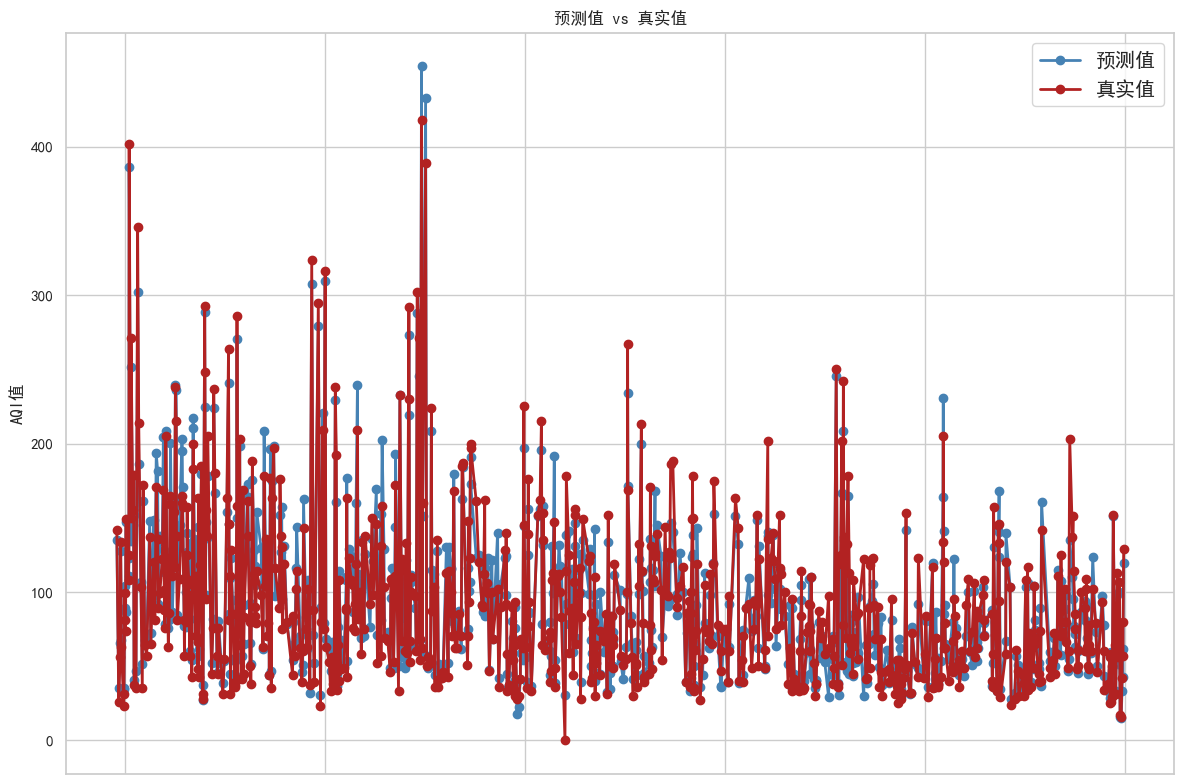

,日期,AQI预测值,AQI真实值
0,2013-12-02 00:00:00,134.860000,142
1,2013-12-09 00:00:00,35.180000,26
2,2013-12-14 00:00:00,65.500000,56
3,2013-12-16 00:00:00,127.370000,134
4,2013-12-19 00:00:00,67.720000,63
5,2013-12-27 00:00:00,34.510000,23
6,2013-12-28 00:00:00,35.300000,31
7,2013-12-31 00:00:00,103.960000,99
8,2014-01-01 00:00:00,89.020000,81
9,2014-01-03 00:00:00,86.760000,74


           日期  AQI预测值  AQI真实值
0  2013-12-02  134.86     142
1  2013-12-09   35.18      26
2  2013-12-14   65.50      56
3  2013-12-16  127.37     134
4  2013-12-19   67.72      63
5  2013-12-27   34.51      23
6  2013-12-28   35.30      31
7  2013-12-31  103.96      99
8  2014-01-01   89.02      81
9  2014-01-03   86.76      74
10 2014-01-04  147.20     149
11 2014-01-14  110.74     108
12 2014-01-15  122.92     125
13 2014-01-16  386.77     402
14 2014-01-22  134.08     150
15 2014-01-23  251.83     271
16 2014-01-29  145.27     155
17 2014-02-01  152.15     179
18 2014-02-03   40.47      37
19 2014-02-10   46.66      35


In [29]:
# 提取特征列
X = data[['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3_8h']]
# 提取目标列（AQI）
y = data['AQI']

# 将数据集划分成训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用线性回归模型进行训练
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# 对测试集数据进行预测
y_pred = linear_reg.predict(X_test)

# 计算均方误差和R^2得分
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('R^2 Score:', r2)


# 首先，我们需要获取预测结果和日期信息。
# 在分割测试集和训练集之前，提取日期列
date = data['日期']

# 划分数据集时，也需要切分日期列
date_train, date_test = train_test_split(date, test_size=0.2, random_state=42)

# 确保日期被排序
date_test_sorted = date_test.sort_values()

# 对应的排序预测值和真实值
y_pred_sorted = y_pred[date_test.argsort()]
y_test_sorted = np.array(y_test)[date_test.argsort()]

# 打印一部分预测结果和真实AQI, 并且预测值只保留两位小数
for date, pred, true in zip(date_test_sorted[:10], y_pred_sorted[:10], y_test_sorted[:10]):
    print(f"日期: {date}, 预测AQI: {pred:.2f}, 真实AQI: {true}")

# 设置seaborn的风格
sns.set_theme(style="whitegrid")

# 创建图形，设置大小
fig, ax = plt.subplots(figsize=(12, 8))

# 绘制预测结果曲线，这里添加了linestyle和marker的选项，linestyle控制线的类型，marker控制点的大小
ax.plot_date(date_test_sorted, y_pred_sorted, color='steelblue', linestyle='-', markersize=6, label='预测值', linewidth=2)

# 绘制实际结果曲线
ax.plot_date(date_test_sorted, y_test_sorted, color='firebrick', linestyle='-', markersize=6, label='真实值', linewidth=2)

# 添加标题和标签
ax.set_title('预测值 vs 真实值')
ax.set_ylabel('AQI值')

# 隐藏X轴的tick labels
ax.axes.get_xaxis().set_ticklabels([])

# 添加图例，设置字体大小
ax.legend(fontsize='large')

# 显示网格
ax.grid(True)

plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False


# 美化布局
plt.tight_layout()

# 显示图形
plt.show()


# 创建一个新的DataFrame来保存结果
result_df = pd.DataFrame()



# 在DataFrame中添加日期，预测的AQI值和真实的AQI值
result_df['日期'] = date_test_sorted[:20].reset_index(drop=True)  # reset_index(drop=True)用于重设索引
result_df['AQI预测值'] = np.round(y_pred_sorted[:20], 2)    # np.round(_, 2)用于四舍五入，保留两位小数
result_df['AQI真实值'] = y_test_sorted[:20]

# 使用 .head() 方法获取前20条数据
results_head = result_df.head(20)

# 设置数据显示为居中格式
results_styler = results_head.style.set_properties(**{'text-align': 'center'})

# 显示居中对齐的前100条数据
display(results_styler)

# 打印出结果
print(result_df)

#### 数据可视化

In [ ]:
selected_qualities = ['优', '重度污染']   #选中质量等级
selected_columns = ['质量等级', '季节']
df_temp = data[data['质量等级'].isin(selected_qualities)][selected_columns].copy()  # 这里我们使用.copy()来创建一个新的DataFrame

# 创建季节和质量等级的交叉表，这将作为我们流的宽度。
value = pd.crosstab(df_temp['季节'], df_temp['质量等级']).stack().reset_index().rename(columns={0:'value'})

# 创建源和目标的列表。使用df_temp，原始的data保持不变。
source = value['季节'].apply(lambda x: df_temp['季节'].unique().tolist().index(x))
target = value['质量等级'].apply(lambda x: df_temp['质量等级'].unique().tolist().index(x) + len(df_temp['季节'].unique()))

# 创建标签，同样使用df_temp。
label = df_temp['季节'].unique().tolist() + df_temp['质量等级'].unique().tolist()

# 创建桑基图的数据
data_draw = go.Sankey(node = dict(label = label, pad = 15, thickness = 20, line = dict(color = "black", width = 0.5)),
                 link = dict(source = source, target = target, value = value['value']))

# 创建图形
fig = go.Figure(data_draw)

# 显示图形
fig.show()



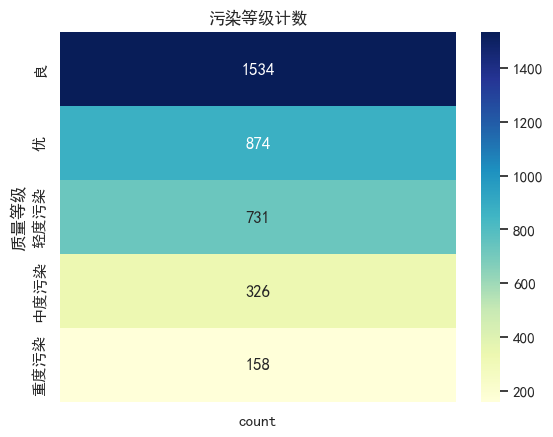

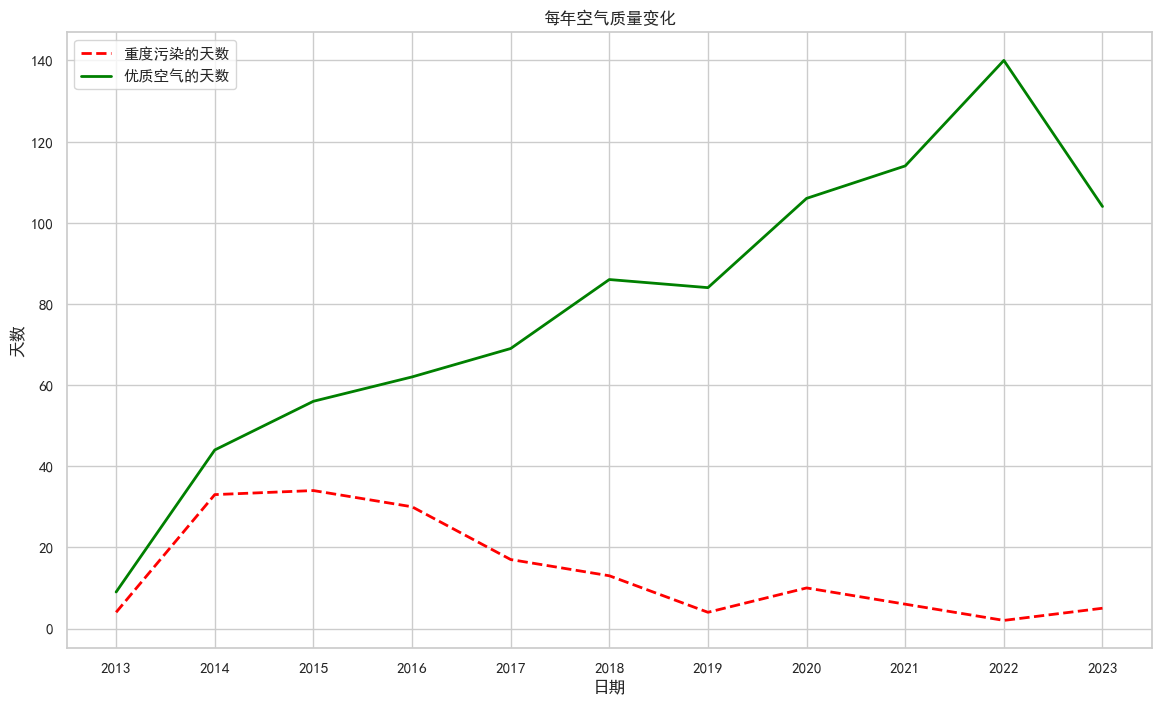

质量等级的所有种类：
['轻度污染' '良' '中度污染' '重度污染' '优' '严重污染' '无']


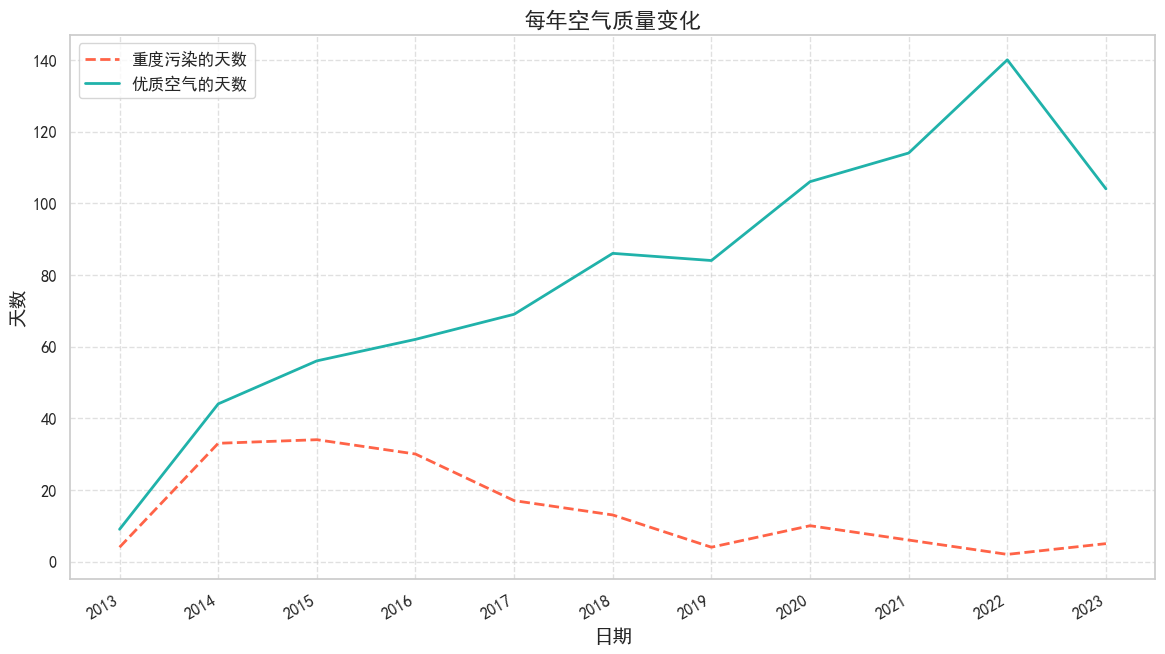

In [ ]:
# 污染等级计数绘图
pollution_counts = data['质量等级'].value_counts()
# 只保留你想要的等级的计数
pollution_counts = pollution_counts[pollution_counts.index.isin(['中度污染', '重度污染', '轻度污染', '良', '优'])]
# 创建热度图
sns.heatmap(pollution_counts.to_frame(), annot=True, fmt='d', cmap='YlGnBu')
plt.title("污染等级计数")
plt.show()


# 分别筛选出质量等级为'重度污染'和'优'的数据
severe_pollution_data = data[data['质量等级']=='重度污染']
excellent_quality_data = data[data['质量等级']=='优']

# 计算每年重度污染和优质空气的天数
severe_days_per_year = severe_pollution_data.groupby(severe_pollution_data['日期'].dt.to_period("Y")).size()
excellent_days_per_year = excellent_quality_data.groupby(excellent_quality_data['日期'].dt.to_period("Y")).size()

plt.figure(figsize=(14,8))

# 绘制两个折线图，分别对应重度污染和优质空气的天数
plt.plot(severe_days_per_year.index.astype(str), severe_days_per_year.values, color='red', linestyle='dashed', linewidth=2, label='重度污染的天数')
plt.plot(excellent_days_per_year.index.astype(str), excellent_days_per_year.values, color='green', linestyle='solid', linewidth=2, label='优质空气的天数')

plt.xlabel('日期')
plt.ylabel('天数')
plt.title('每年空气质量变化')
plt.grid(True)

# 添加图例来标明每条线条代表的含义
plt.legend()

plt.show()


unique_grades = data['质量等级'].unique()
print("质量等级的所有种类：")
print(unique_grades)



# 设置图像的大小
fig, ax = plt.subplots(figsize=(14, 8))

# 在同一图框中画两个折线图
ax.plot(severe_days_per_year.index.astype(str), severe_days_per_year.values, color='tomato', linestyle='--', linewidth=2, label='重度污染的天数')
ax.plot(excellent_days_per_year.index.astype(str), excellent_days_per_year.values, color='lightseagreen', linestyle='-', linewidth=2, label='优质空气的天数')

# 设置横轴和纵轴的标题、字体大小
ax.set_xlabel('日期', fontsize=14)
ax.set_ylabel('天数', fontsize=14)

# 设置主标题的内容、字体大小
ax.set_title('每年空气质量变化', fontsize=16)

# 自动旋转日期标记以避免重叠
plt.gcf().autofmt_xdate()

# 设置刻度的字体大小，使其明显
ax.tick_params(axis='both', labelsize=12)

# 设置网格线
ax.grid(True, linestyle='--', alpha=0.6)

# 添加图例，设置字体大小
ax.legend(fontsize=12)

# 显示图像
plt.show()

#### 下面是使用随机森林算法对质量等级进行分类预测

预测的准确率是： 0.932157394843962


,准确率,召回率,精确率,F1
训练集,1.000000,1.000000,1.000000,1.000000
测试集,0.932157,0.932157,0.931865,0.930269


,真实值,预测值,严重污染预测概率,中度污染预测概率,优预测概率,无预测概率,良预测概率,轻度污染预测概率,重度污染预测概率
1097,严重污染,重度污染,0.380000,0.070000,0.000000,0.000000,0.010000,0.010000,0.530000
2784,优,优,0.000000,0.000000,0.810000,0.000000,0.190000,0.000000,0.000000
2440,良,良,0.000000,0.000000,0.010000,0.000000,0.880000,0.110000,0.000000
1694,优,优,0.000000,0.000000,0.830000,0.000000,0.170000,0.000000,0.000000
2494,良,良,0.000000,0.010000,0.300000,0.000000,0.690000,0.000000,0.000000
2270,轻度污染,轻度污染,0.010000,0.100000,0.000000,0.000000,0.230000,0.620000,0.040000
3477,良,良,0.000000,0.000000,0.040000,0.000000,0.940000,0.020000,0.000000
937,良,良,0.000000,0.040000,0.020000,0.000000,0.610000,0.330000,0.000000
495,中度污染,中度污染,0.020000,0.440000,0.000000,0.000000,0.130000,0.240000,0.170000
798,重度污染,重度污染,0.080000,0.260000,0.000000,0.000000,0.060000,0.140000,0.460000


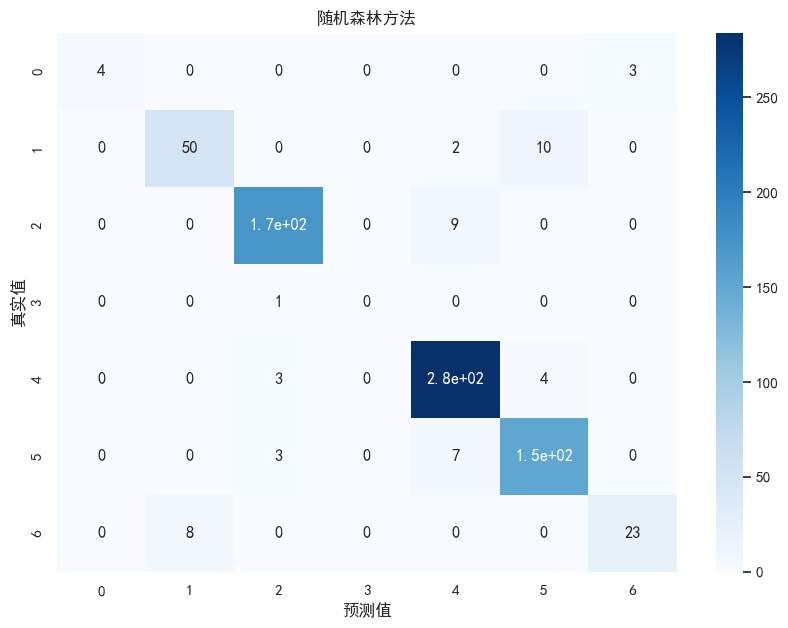

In [ ]:
# 将data的值复制到df当中
df = data

df = df.drop(columns='AQI')


# 缺失值处理
# 使用列的中位数来填充NaN
# median = df['质量等级'].median()
# df['质量等级'].fillna(median, inplace=True)


# 执行独热编码转换类别字段
df = pd.get_dummies(df, columns=['季节'])
df = pd.get_dummies(df, columns=['日期'])

# 在我们进行预测前，我们需要将数据集划分为训练集和验证集
X = df.drop(columns='质量等级')
y = df['质量等级']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 使用随机森林分类器进行训练
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# 进行预测并检查准确率
predictions = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("预测的准确率是：", accuracy)
# 概率
predicted_proba = classifier.predict_proba(X_test)

# 计算混淆矩阵并创建热力图
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.title('随机森林方法')
plt.xlabel('预测值')
plt.ylabel('真实值')



# 训练集上的预测
train_predictions = classifier.predict(X_train)
# 计算准确率、召回率、精确率 和 F1分数
accuracy_train = classifier.score(X_train, y_train)
recall_train = recall_score(y_train, train_predictions, average='weighted')
precision_train = precision_score(y_train, train_predictions, average='weighted',zero_division=1)
f1_train = f1_score(y_train, train_predictions, average='weighted')
accuracy_test = accuracy
recall_test = recall_score(y_test, predictions, average='weighted')
precision_test = precision_score(y_test, predictions, average='weighted',zero_division=1)
f1_test = f1_score(y_test, predictions, average='weighted')
# 创建 DataFrame
performance = pd.DataFrame({
    '准确率': [accuracy_train, accuracy_test],
    '召回率': [recall_train, recall_test],
    '精确率': [precision_train, precision_test],
    'F1': [f1_train, f1_test]
}, index = ['训练集', '测试集'])
# 显示 performance
performance_styler = performance.style.set_properties(**{'text-align': 'center'})
display(performance_styler)
# 构建预测结果对照表
results = pd.DataFrame({
    '真实值': y_test,
    '预测值': predictions
})

# 获得类别列表，按照模型内部的顺序
class_list = classifier.classes_

# 将预测的概率与其对应的类别关联起来
for i, quality_level in enumerate(class_list):
    results[f'{quality_level}预测概率'] = predicted_proba[:, i]

# 使用 .head() 方法获取前20条数据
results_head = results.head(20)

# 设置数据显示为居中格式
results_styler = results_head.style.set_properties(**{'text-align': 'center'})

# 显示居中对齐的前100条数据
display(results_styler)



#### 支持向量机方法进行分类预测

预测准确率： 0.8873812754409769
预测的准确率是： 0.8873812754409769


,准确率,召回率,精确率,F1
训练集,0.896060,0.896060,0.896653,0.895085
测试集,0.887381,0.887381,0.888241,0.886638


,真实值,预测值,严重污染预测概率,中度污染预测概率,优预测概率,无预测概率,良预测概率,轻度污染预测概率,重度污染预测概率
1097,严重污染,重度污染,0.404001,0.005605,0.002082,0.008329,0.002334,0.002063,0.575586
2784,优,优,0.001215,0.000975,0.975534,0.000348,0.018287,0.002891,0.000751
2440,良,良,0.001780,0.004756,0.004784,0.001447,0.717070,0.268339,0.001824
1694,优,优,0.001251,0.000943,0.990655,0.000730,0.003787,0.001931,0.000703
2494,良,良,0.000713,0.000838,0.149498,0.000962,0.842679,0.004704,0.000606
2270,轻度污染,轻度污染,0.001272,0.057116,0.002133,0.000493,0.017870,0.915754,0.005362
3477,良,良,0.001914,0.001698,0.413752,0.001946,0.566434,0.013069,0.001186
937,良,轻度污染,0.000727,0.003817,0.000525,0.000379,0.242277,0.751532,0.000744
495,中度污染,中度污染,0.004145,0.911572,0.001536,0.001865,0.006188,0.035078,0.039616
798,重度污染,重度污染,0.010477,0.005602,0.000972,0.005288,0.001086,0.001197,0.975379


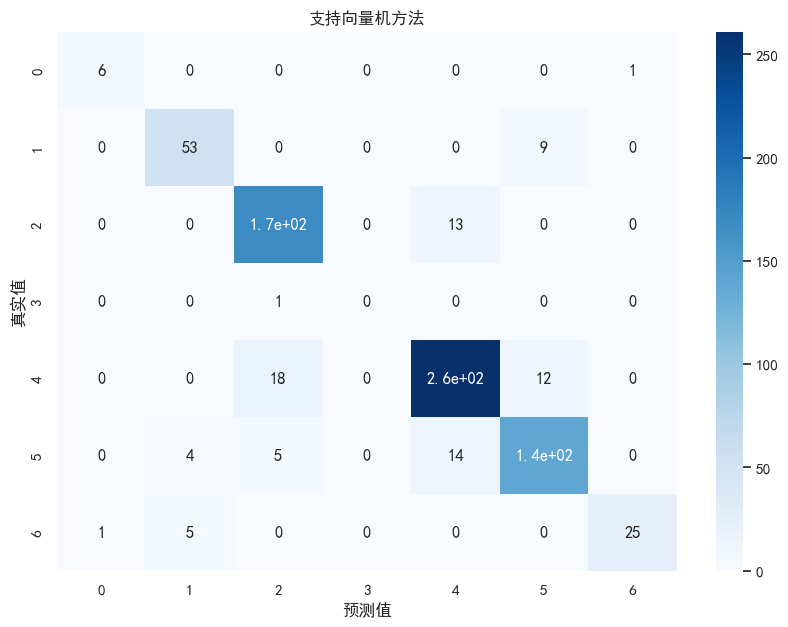

In [ ]:

# 使用支持向量机分类器进行训练
classifier = svm.SVC(probability=True)
classifier.fit(X_train, y_train)

# 执行预测并计算准确度
predictions = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("预测准确率：", accuracy)

# 概率
predicted_proba = classifier.predict_proba(X_test)

# 进行预测并检查准确率
predictions = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("预测的准确率是：", accuracy)
# 概率
predicted_proba = classifier.predict_proba(X_test)

# 计算混淆矩阵并创建热力图
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.title('支持向量机方法')
plt.xlabel('预测值')
plt.ylabel('真实值')



# 训练集上的预测
train_predictions = classifier.predict(X_train)
# 计算准确率、召回率、精确率 和 F1分数
accuracy_train = classifier.score(X_train, y_train)
recall_train = recall_score(y_train, train_predictions, average='weighted')
precision_train = precision_score(y_train, train_predictions, average='weighted',zero_division=1)
f1_train = f1_score(y_train, train_predictions, average='weighted')
accuracy_test = accuracy
recall_test = recall_score(y_test, predictions, average='weighted')
precision_test = precision_score(y_test, predictions, average='weighted',zero_division=1)
f1_test = f1_score(y_test, predictions, average='weighted')
# 创建 DataFrame
performance = pd.DataFrame({
    '准确率': [accuracy_train, accuracy_test],
    '召回率': [recall_train, recall_test],
    '精确率': [precision_train, precision_test],
    'F1': [f1_train, f1_test]
}, index = ['训练集', '测试集'])
# 显示 performance
performance_styler = performance.style.set_properties(**{'text-align': 'center'})
display(performance_styler)
# 构建预测结果对照表
results = pd.DataFrame({
    '真实值': y_test,
    '预测值': predictions
})

# 获得类别列表，按照模型内部的顺序
class_list = classifier.classes_

# 将预测的概率与其对应的类别关联起来
for i, quality_level in enumerate(class_list):
    results[f'{quality_level}预测概率'] = predicted_proba[:, i]

# 使用 .head() 方法获取前20条数据
results_head = results.head(20)

# 设置数据显示为居中格式
results_styler = results_head.style.set_properties(**{'text-align': 'center'})

# 显示居中对齐的前100条数据
display(results_styler)



### bp神经网络进行分类预测

预测准确率： 0.7896879240162822
预测的准确率是： 0.7896879240162822


,准确率,召回率,精确率,F1
训练集,1.000000,1.000000,1.000000,1.000000
测试集,0.789688,0.789688,0.784989,0.781462


,真实值,预测值,严重污染预测概率,中度污染预测概率,优预测概率,无预测概率,良预测概率,轻度污染预测概率,重度污染预测概率
1097,严重污染,重度污染,0.425941,0.008131,0.000000,0.000000,0.000000,0.000002,0.565926
2784,优,优,0.000022,0.000300,0.768527,0.000012,0.228701,0.002358,0.000080
2440,良,良,0.000257,0.068559,0.001640,0.000002,0.598706,0.317263,0.013572
1694,优,优,0.000002,0.000012,0.944331,0.000006,0.055491,0.000155,0.000004
2494,良,良,0.000060,0.000738,0.033935,0.000002,0.947052,0.017890,0.000323
2270,轻度污染,重度污染,0.034794,0.278595,0.000000,0.000000,0.005019,0.060574,0.621019
3477,良,良,0.000076,0.003826,0.178600,0.000029,0.780321,0.036153,0.000995
937,良,轻度污染,0.000107,0.149295,0.000177,0.000000,0.394247,0.439245,0.016929
495,中度污染,重度污染,0.023724,0.276274,0.000000,0.000000,0.000255,0.002692,0.697055
798,重度污染,严重污染,0.662687,0.003755,0.000000,0.000000,0.000000,0.000000,0.333558


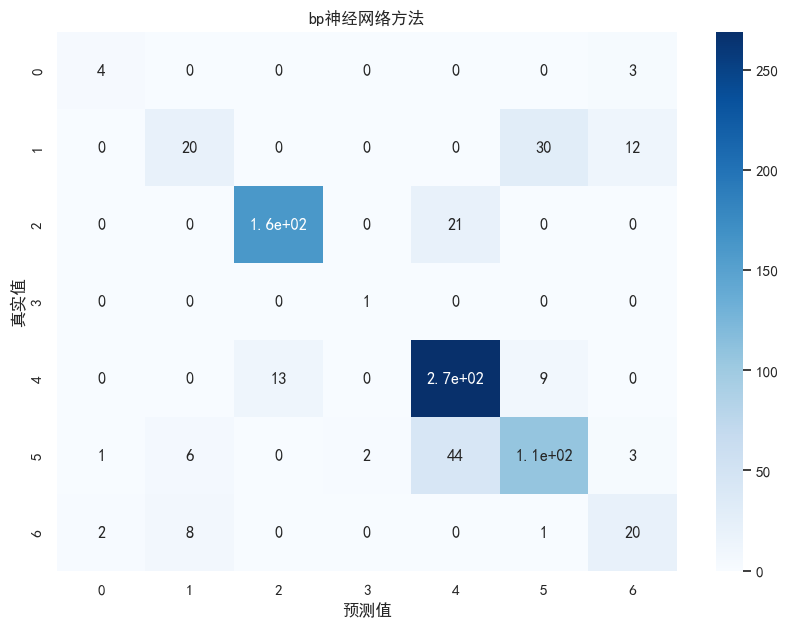

In [ ]:
# 使用MLP神经网络（这里的MLP即为BP神经网络）进行训练
classifier = MLPClassifier(random_state=42, max_iter=300)

classifier.fit(X_train, y_train)

# 执行预测并计算准确率
predictions = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("预测准确率：", accuracy)

# 概率
predicted_proba = classifier.predict_proba(X_test)

# 进行预测并检查准确率
predictions = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("预测的准确率是：", accuracy)
# 概率
predicted_proba = classifier.predict_proba(X_test)

# 计算混淆矩阵并创建热力图
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.title('bp神经网络方法')
plt.xlabel('预测值')
plt.ylabel('真实值')



# 训练集上的预测
train_predictions = classifier.predict(X_train)
# 计算准确率、召回率、精确率 和 F1分数
accuracy_train = classifier.score(X_train, y_train)
recall_train = recall_score(y_train, train_predictions, average='weighted')
precision_train = precision_score(y_train, train_predictions, average='weighted',zero_division=1)
f1_train = f1_score(y_train, train_predictions, average='weighted')
accuracy_test = accuracy
recall_test = recall_score(y_test, predictions, average='weighted')
precision_test = precision_score(y_test, predictions, average='weighted',zero_division=1)
f1_test = f1_score(y_test, predictions, average='weighted')
# 创建 DataFrame
performance = pd.DataFrame({
    '准确率': [accuracy_train, accuracy_test],
    '召回率': [recall_train, recall_test],
    '精确率': [precision_train, precision_test],
    'F1': [f1_train, f1_test]
}, index = ['训练集', '测试集'])
# 显示 performance
performance_styler = performance.style.set_properties(**{'text-align': 'center'})
display(performance_styler)
# 构建预测结果对照表
results = pd.DataFrame({
    '真实值': y_test,
    '预测值': predictions
})

# 获得类别列表，按照模型内部的顺序
class_list = classifier.classes_

# 将预测的概率与其对应的类别关联起来
for i, quality_level in enumerate(class_list):
    results[f'{quality_level}预测概率'] = predicted_proba[:, i]

# 使用 .head() 方法获取前20条数据
results_head = results.head(20)

# 设置数据显示为居中格式
results_styler = results_head.style.set_properties(**{'text-align': 'center'})

# 显示居中对齐的前100条数据
display(results_styler)



#### 使用XGBOOST进行分类预测
注意质量等级这一列目前必须要encode成整型才能使用xgboost

d:\Software\Python\Lib\site-packages\xgboost\core.py:160: UserWarning:

[10:41:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


d:\Software\Python\Lib\site-packages\xgboost\core.py:160: UserWarning:

[10:41:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "C", "kernel" } are not used.


d:\Software\Python\Lib\site-packages\xgboost\core.py:160: UserWarning:

[10:41:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `dev

预测的准确率是： 0.9972862957937585


,准确率,召回率,精确率,F1
训练集,0.999660,0.999660,0.999662,0.999660
测试集,0.997286,0.997286,0.997456,0.997326


,真实值,预测值,0 预测概率,1 预测概率,2 预测概率,3 预测概率,4 预测概率,5 预测概率,6 预测概率
0,0,0,0.849880,0.000282,0.000963,0.001583,0.001013,0.000810,0.145468
1,2,2,0.000022,0.000038,0.999727,0.000022,0.000096,0.000065,0.000031
2,4,4,0.000020,0.000034,0.000012,0.000020,0.999828,0.000058,0.000028
3,2,2,0.000022,0.000038,0.999758,0.000022,0.000096,0.000065,0.000000
4,4,4,0.000020,0.000034,0.000012,0.000020,0.999828,0.000058,0.000028
5,5,5,0.000030,0.000052,0.000018,0.000030,0.000019,0.999809,0.000042
6,4,4,0.000020,0.000034,0.000012,0.000020,0.999828,0.000058,0.000028
7,4,4,0.000020,0.000034,0.000012,0.000020,0.999828,0.000058,0.000028
8,1,1,0.000063,0.998896,0.000038,0.000062,0.000040,0.000032,0.000869
9,6,6,0.000001,0.000000,0.000000,0.000001,0.000000,0.000000,0.999998


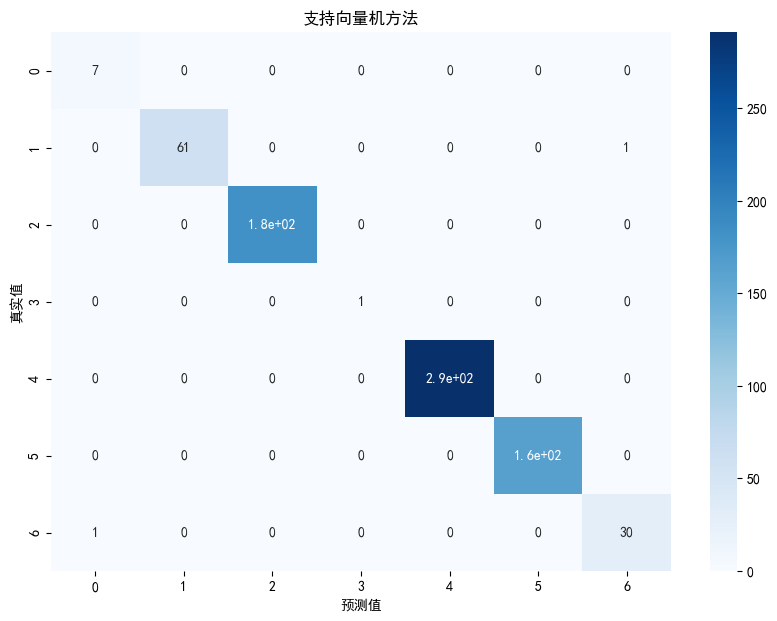

In [ ]:
# 首先做数据集的随机划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = xgb.XGBClassifier(use_label_encoder=True, eval_metric='mlogloss', random_state=99, learning_rate=2.30, tree_method='gpu_hist')
# 创建一个LabelEncoder对象并同时对训练数据和测试数据进行编码
le = preprocessing.LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# 定义需要优化的参数和参数取值范围
param_grid = {'C': np.logspace(-3, 2, 6), 'gamma': np.logspace(-3, 2, 6), 'kernel': ['rbf']}

# 定义目标函数（以模型在验证集上的准确率为优化目标）
def objective(params):
    classifier.set_params(**params)
    return np.mean(cross_val_score(classifier, X_train, y_train_encoded, cv=5))

# 定义模拟退火过程
def simulated_annealing(classifier, param_grid, T=1.0, T_min=0.00001, alpha=0.9):
    params = {"C": random.choice(param_grid['C']), "gamma": random.choice(param_grid['gamma']), "kernel": 'rbf'}
    while T > T_min:
        new_params = {"C": random.choice(param_grid['C']), "gamma": random.choice(param_grid['gamma']), "kernel": 'rbf'}
        old_energy = objective(params)
        new_energy = objective(new_params)
        p_accept = np.exp((old_energy - new_energy) / T)
        if new_energy < old_energy or np.random.rand() < p_accept:
            params = new_params
        T = T*alpha
    return params

# 使用模拟退火方式找到最佳参数
best_params = simulated_annealing(classifier, param_grid)
classifier.set_params(**best_params)

# 训练
classifier.fit(X_train, y_train_encoded)

# 预测
predictions = classifier.predict(X_test)

# 准确率
accuracy = accuracy_score(y_test_encoded, predictions)
print("预测的准确率是：", accuracy)

# 混淆矩阵
cm = confusion_matrix(y_test_encoded, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.title('XGBoost-模拟退火参数优化')
plt.xlabel('预测值')
plt.ylabel('真实值')

# 训练集预测
train_predictions = classifier.predict(X_train)
accuracy_train = classifier.score(X_train, y_train_encoded)
recall_train = recall_score(y_train_encoded, train_predictions, average='weighted')
precision_train = precision_score(y_train_encoded, train_predictions, average='weighted',zero_division=1)
f1_train = f1_score(y_train_encoded, train_predictions, average='weighted')

# 测试集预测
accuracy_test = accuracy
recall_test = recall_score(y_test_encoded, predictions, average='weighted')
precision_test = precision_score(y_test_encoded, predictions, average='weighted',zero_division=1)
f1_test = f1_score(y_test_encoded, predictions, average='weighted')

# 汇总
performance = pd.DataFrame({
    '准确率': [accuracy_train, accuracy_test],
    '召回率': [recall_train, recall_test],
    '精确率': [precision_train, precision_test],
    'F1': [f1_train, f1_test]
}, index=['训练集', '测试集'])

# 显示
performance_styler = performance.style.set_properties(**{'text-align': 'center'})
display(performance_styler)

# 概率
predicted_proba = classifier.predict_proba(X_test)
results = pd.DataFrame({
    '真实值': y_test_encoded,
    '预测值': predictions
})
class_list = classifier.classes_
for i, quality_level in enumerate(class_list):
    results[f'{quality_level} 预测概率'] = predicted_proba[:, i]

# 获取前20条数据
results_head = results.head(20)

# 格式设置
results_styler = results_head.style.set_properties(**{'text-align': 'center'})

# 显示前20条数据
display(results_styler)